# This notebook explores the data, filters out outliers, and saves the data as data_filetered.parquet.

In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
from tqdm.notebook import tqdm

def process_notebook(notebook_path):
    with open(notebook_path, 'r', encoding='utf-8') as file:
        notebook = json.load(file)
        
    output = []
    
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code' and cell['source']:
            code = ''.join(cell['source'])
            output.append(code)
    
        elif cell['cell_type'] == 'markdown' and cell['source']:
            markdown = ''.join(cell['source'])
            output.append(markdown)
    
    code = "\n".join(output)
    line_count = code.count('\n')
    char_count = len(code)
    
    return code, line_count, char_count

In [2]:
def compile_dataframes(directory):
    all_data = []  # This will store data from all notebooks
    for filename in tqdm(os.listdir(directory), desc="Processing Notebooks"):

    # for filename in os.listdir(directory):
        if filename.endswith('.ipynb'):
            file_path = os.path.join(directory, filename)
            try:
                notebook_data, line_count, char_count = process_notebook(file_path)
                all_data.append({'filename': filename, 'notebook_data': notebook_data, 'line_count': line_count, 'char_count': char_count})
            except Exception as e:
                # print(f"Error processing {filename}: {e}")
                pass # Skip this notebook 

    df = pd.DataFrame(all_data)
    return df


In [3]:
directory_path = 'all_ipynbs'
# directory_path = 'small_train'
df = compile_dataframes(directory_path)
df

Processing Notebooks:   0%|          | 0/207470 [00:00<?, ?it/s]

,filename,notebook_data,line_count,char_count
0,1000010.ipynb,import pandas as pd\nimport seaborn as sns\nim...,44,2895
1,1000013.ipynb,## Introduction\n\nWorking with these files ca...,302,15165
2,1000014.ipynb,# This Python 3 environment comes with many he...,41,1268
3,1000018.ipynb,# This Python 3 environment comes with many he...,58,3119
4,1000025.ipynb,"As the name says, all I am doing here is clean...",122,6354
...,...,...,...,...
207102,999975.ipynb,Pollution in USA\n----------------\n![enter im...,235,4911
207103,999980.ipynb,# Mean-Encoding High Cardinality Categoricals ...,128,5854
207104,999988.ipynb,**<h1>LEAF CLASSIFICATION</h1>**\n# Package Im...,91,3590
207105,999993.ipynb,This notebook is to extract fish from image.\n...,96,2692


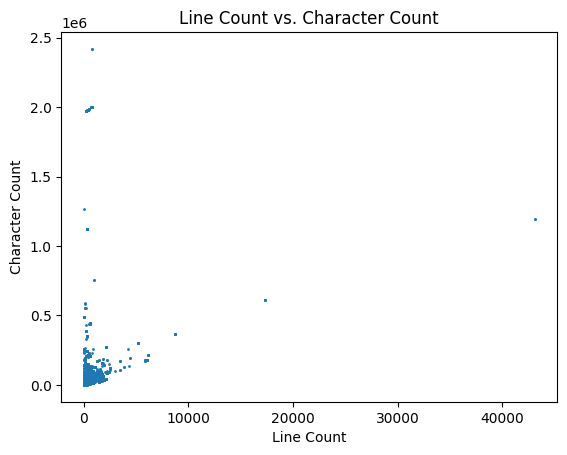

In [4]:
plt.scatter(df['line_count'], df['char_count'], s=1)
plt.xlabel('Line Count')
plt.ylabel('Character Count')
plt.title('Line Count vs. Character Count')
plt.show()

In [5]:
def plot_histograms(feature1, title1, x_label1, feature2, title2, x_label2):
    plt.figure(figsize=(12, 6))

    # First histogram
    plt.subplot(1, 2, 1)
    df[feature1].hist(bins=60)
    plt.xlabel(x_label1)
    plt.ylabel('Frequency')
    plt.title(title1)

    # Second histogram
    plt.subplot(1, 2, 2)
    df[feature2].hist(bins=60)
    plt.xlabel(x_label2)
    plt.ylabel('Frequency')
    plt.title(title2)

    plt.tight_layout()
    plt.show()

In [6]:
# Drop extremes
df = df[df['line_count'] < 400]
df = df[df['char_count'] < 15_000]

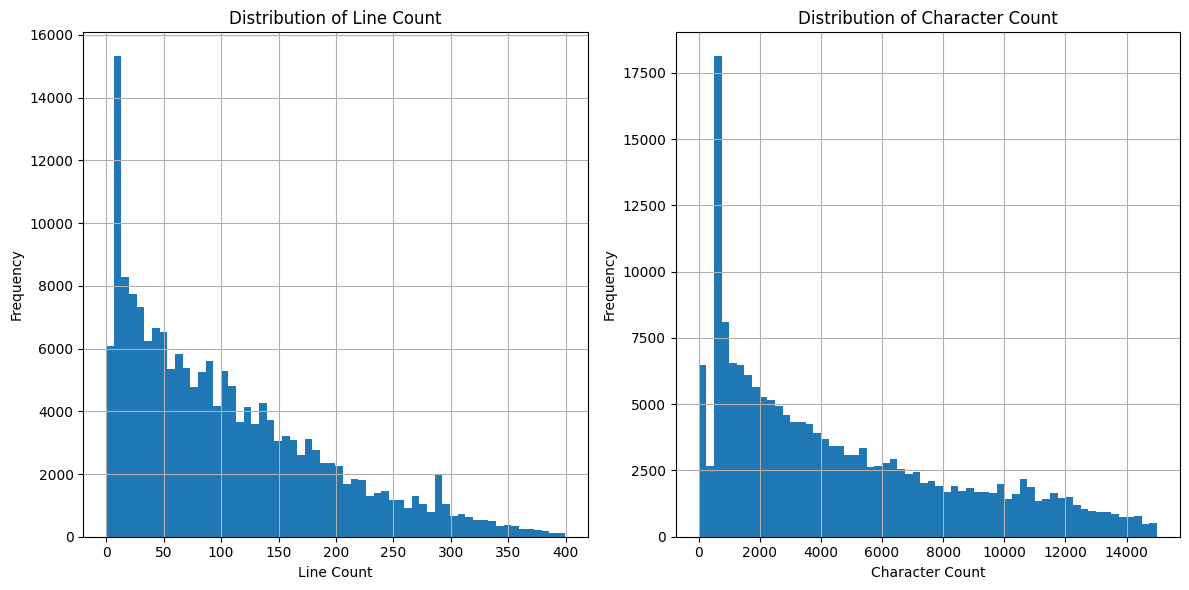

In [7]:
plot_histograms('line_count', 'Distribution of Line Count', 'Line Count', 'char_count', 'Distribution of Character Count', 'Character Count')

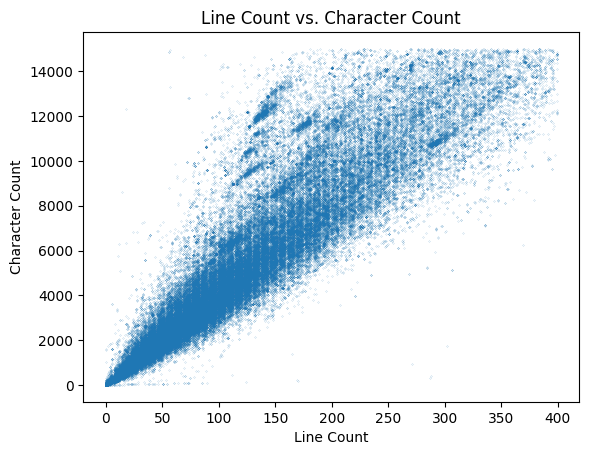

In [8]:
plt.scatter(df['line_count'], df['char_count'], s= 0.01)
plt.xlabel('Line Count')
plt.ylabel('Character Count')
plt.title('Line Count vs. Character Count')
plt.show()

In [9]:
df.describe()

,line_count,char_count
count,179351.000000,179351.000000
mean,105.103691,4659.256263
std,85.821418,3860.462020
min,0.000000,0.000000
25%,34.000000,1361.000000
50%,85.000000,3547.000000
75%,156.000000,7163.000000
max,399.000000,14999.000000


In [10]:
# Remove outliers
x = df['line_count']
y = df['char_count']

# Fit the linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
y_pred = slope * x + intercept
residuals = y - y_pred
residuals_std = np.std(residuals)

outliers = np.abs(residuals) > residuals_std

# Filter points that are NOT outliers
x_filtered = x[~outliers]
y_filtered = y[~outliers]

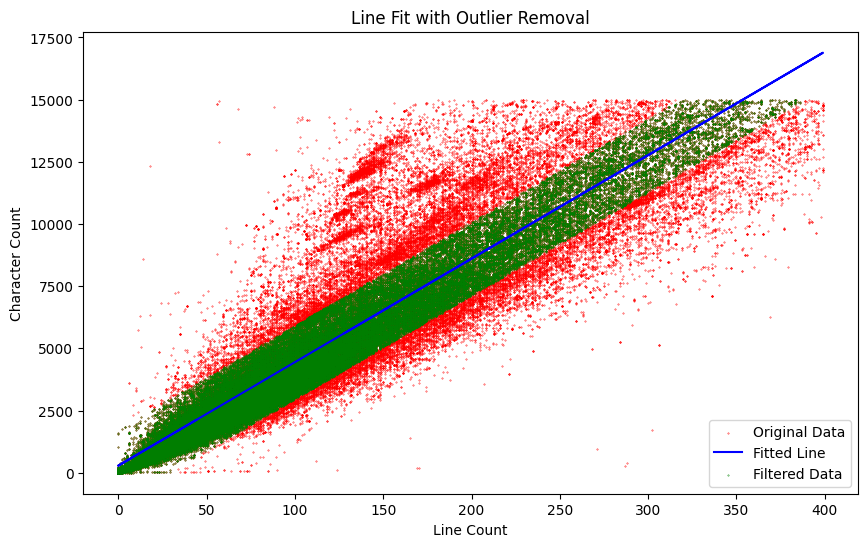

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='red', label='Original Data', s=0.1)
plt.plot(x, y_pred, color='blue', label='Fitted Line')
plt.scatter(x_filtered, y_filtered, color='green', label='Filtered Data', s=0.1)
plt.xlabel('Line Count')
plt.ylabel('Character Count')
plt.title('Line Fit with Outlier Removal')
plt.legend()
plt.show()

In [12]:
df_filtered = df[~outliers]
df_filtered.describe()

,line_count,char_count
count,144395.000000,144395.000000
mean,84.816178,3592.064026
std,74.975788,3196.419286
min,0.000000,0.000000
25%,25.000000,1029.000000
50%,64.000000,2611.000000
75%,120.000000,5194.000000
max,386.000000,14999.000000


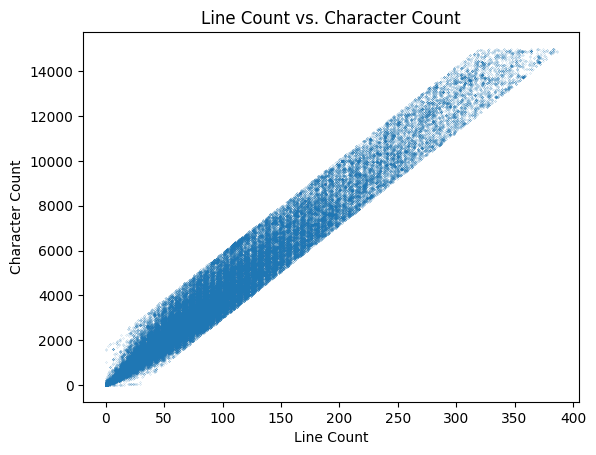

In [13]:
plt.scatter(df_filtered['line_count'], df_filtered['char_count'], s= 0.01)
plt.xlabel('Line Count')
plt.ylabel('Character Count')
plt.title('Line Count vs. Character Count')
plt.show()

In [14]:
df_filtered.to_parquet('data_filtered.parquet', engine='pyarrow')
